In [ ]:
# 02_metrics_teardown.ipynb
#
# Analyzes product-level engagement and monetization metrics for Streamly.
# 
# This notebook loads simulated user and event data, computes:
# - Cohort-based retention rates
# - ARPU and its components (AOV × Frequency × Active Users)
#
# Outputs:
# - Retention and ARPU tables to data/processed/
# - Visualizations to figures/ for use in reporting or modeling

In [1]:
# Setup & Pathing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Set up paths
CURRENT_DIR = Path().resolve()
BASE_DIR = CURRENT_DIR.parent if CURRENT_DIR.name == "notebooks" else CURRENT_DIR
RAW_DATA_DIR = BASE_DIR / "data" / "raw"
PROCESSED_DATA_DIR = BASE_DIR / "data" / "processed"
FIGURES_DIR = BASE_DIR / "figures"

PROCESSED_DATA_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

In [2]:
#Load Raw Data
users = pd.read_csv(RAW_DATA_DIR / "users.csv", parse_dates=["signup_date"])
events = pd.read_csv(RAW_DATA_DIR / "events.csv", parse_dates=["month"])

print(users.head())
print(events.head())

  user_id region subscription_type signup_date
0     u_0     US           monthly  2023-09-01
1     u_1     EU             trial  2024-05-01
2     u_2     EU           monthly  2024-05-01
3     u_3     US           monthly  2023-09-01
4     u_4     US            annual  2023-11-01
  user_id      month subscription_type region  usage_time  transactions  \
0     u_0 2023-09-01           monthly     US   17.953354             1   
1     u_0 2023-10-01           monthly     US    4.864515             0   
2     u_1 2024-05-01             trial     EU    2.492201             0   
3     u_2 2024-05-01           monthly     EU    4.109075             5   
4     u_2 2024-06-01           monthly     EU   14.197125             2   

   churn_flag  
0           0  
1           1  
2           1  
3           0  
4           0  


In [3]:
# Merge + Cohort Assignment
events = events.merge(users[["user_id", "signup_date"]], on="user_id", how="left")
events["cohort_month"] = events["signup_date"].dt.to_period("M")
events["event_month"] = events["month"].dt.to_period("M")
events["months_since_signup"] = (events["event_month"] - events["cohort_month"]).apply(lambda x: x.n)

events = events[events["months_since_signup"] >= 0]  # filter any invalid rows

In [4]:
# Retention Table
# 1 = retained user in that month
retention = (
    events
    .groupby(["cohort_month", "months_since_signup"])
    .agg(n_active=("user_id", "nunique"))
    .reset_index()
)

# Normalize to cohort size
cohort_sizes = (
    events[events["months_since_signup"] == 0]
    .groupby("cohort_month")["user_id"]
    .nunique()
    .rename("cohort_size")
    .reset_index()
)

retention = retention.merge(cohort_sizes, on="cohort_month")
retention["retention_rate"] = retention["n_active"] / retention["cohort_size"]

retention.to_csv(PROCESSED_DATA_DIR / "retention_table.csv", index=False)

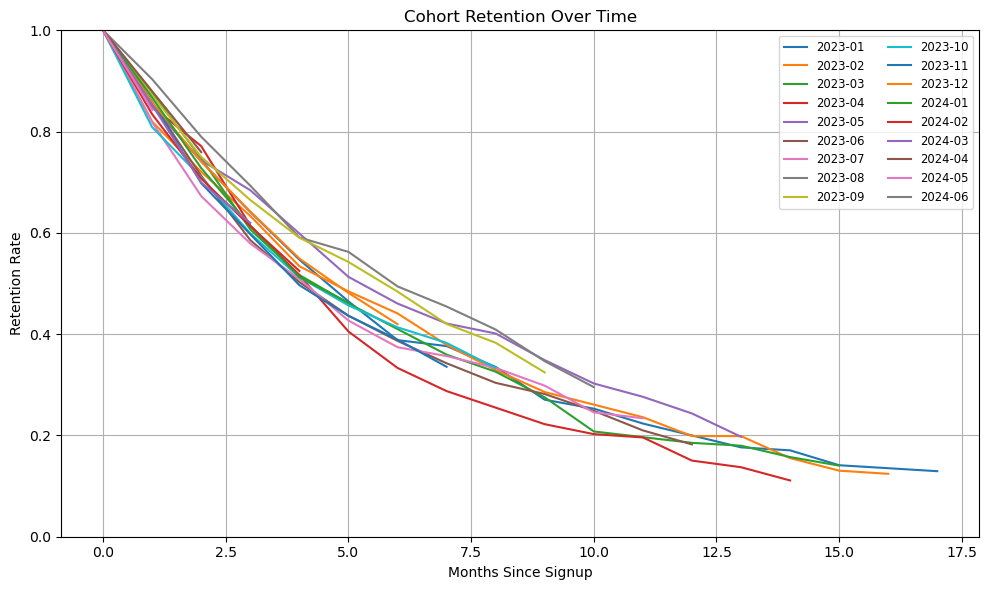

In [5]:
# Plot Retention Curves
plt.figure(figsize=(10, 6))
for cohort, group in retention.groupby("cohort_month"):
    plt.plot(group["months_since_signup"], group["retention_rate"], label=str(cohort))

plt.title("Cohort Retention Over Time")
plt.xlabel("Months Since Signup")
plt.ylabel("Retention Rate")
plt.ylim(0, 1)
plt.grid(True)
plt.legend(loc="upper right", fontsize="small", ncol=2)
plt.tight_layout()
plt.savefig(FIGURES_DIR / "retention_curves.png")
plt.show()

In [6]:
# ARPU Components
arpu_data = (
    events
    .groupby(["month"])
    .agg(
        total_revenue=("transactions", "sum"),  # assume $1 per txn
        total_users=("user_id", "nunique"),
        avg_order_value=("transactions", "mean"),
        purchase_freq=("transactions", "count")
    )
    .reset_index()
)

arpu_data["ARPU"] = arpu_data["total_revenue"] / arpu_data["total_users"]
arpu_data.to_csv(PROCESSED_DATA_DIR / "arpu_by_month.csv", index=False)


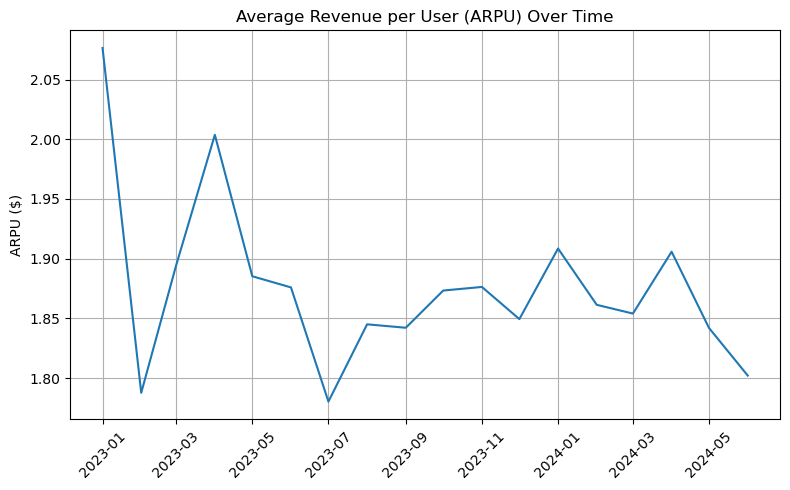

In [7]:
# Bar Plot of ARPU Decomposition
plt.figure(figsize=(8, 5))
plt.plot(arpu_data["month"], arpu_data["ARPU"], label="ARPU")
plt.title("Average Revenue per User (ARPU) Over Time")
plt.ylabel("ARPU ($)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.savefig(FIGURES_DIR / "arpu_decomp.png")
plt.show()
